In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.ops import linemerge

from shapely.geometry import LineString, MultiLineString, GeometryCollection, Point
from shapely.ops import linemerge, split, unary_union
from shapely import geometry, ops
import numpy as np
import shapely
import random


## exploring location data

In [44]:
lmp_map = gpd.read_file("LMP/caiso_lmp.shp") #Nodes locations
ca_map = gpd.read_file("ca_state/CA_State.shp") #California State
highway_map = gpd.read_file("National_Highway_System/National_Highway_System.shp") #California Highway
nodes_all_df = pd.read_csv('LMP_coordinates.csv') #Nodes location and information

In [5]:
I5_map = highway_map[highway_map['RouteID'] == 'SHS_005._S'] #Filtering the I5 from highways
I5_map.head()

,OBJECTID,RouteID,FromARMeas,ToARMeasur,NHS_TYPE,GlobalID,Shape_Leng,geometry
125,126,SHS_005._S,133.220088,701.484348,INTERSTATE,{29CE2E13-D7E5-4291-A922-F178CD8D40CF},1.153111e+06,"LINESTRING Z (-13160352.911 4033449.468 0, -13..."
5365,5366,SHS_005._S,0.000000,117.992793,INTERSTATE,{0C3099B9-BC98-42AC-A7AC-17D714E5B6CB},2.276015e+05,"LINESTRING Z (-13028019.752 3834973.342 0, -13..."
5366,5367,SHS_005._S,118.872048,133.219088,INTERSTATE,{F4047D3C-3173-43F2-BDB6-95CA48CD5E78},2.787594e+04,"LINESTRING Z (-13141151.533 4014693.294 0, -13..."
5369,5370,SHS_005._S,701.484348,796.218359,INTERSTATE,{485E69F2-7289-4178-B060-F57551F27D14},2.037327e+05,"LINESTRING Z (-13623701.526 4995580.819 0, -13..."


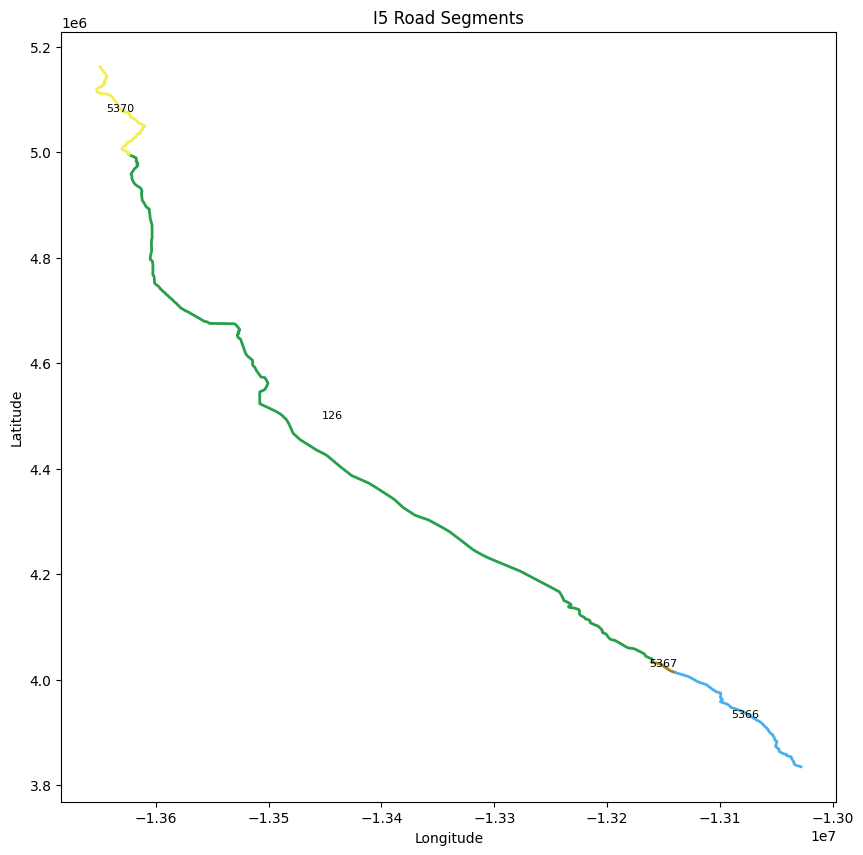

In [8]:
#Visualizing the different portions of I5

fig, ax = plt.subplots(figsize=(10, 10))

# Iterate through each row in the GeoDataFrame
for idx, row in I5_map.iterrows():
    # Generate a random color for each row
    color = (random.random(), random.random(), random.random())  # RGB color
    
    # Extract the coordinates of the LineString
    x, y = row.geometry.xy  # Extract x and y coordinates

    # Plot the geometry of the current row with the generated color
    ax.plot(x, y, color=color, linewidth=2)
    
    # Add the ID (or any other field) as a text label near the geometry
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, str(row['OBJECTID']),
            fontsize=8, ha='center', color='black')

# Add labels and title to the plot
ax.set_title('I5 Road Segments')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


<Axes: >

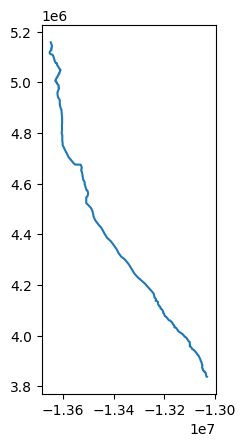

In [9]:
#Merging the I5 into one unique line

object_ids = [5370, 126, 5367, 5366]
geometries = [I5_map[I5_map['OBJECTID'] == obj_id].geometry.iloc[0] for obj_id in object_ids]

# Define a function to align and join two LineStrings
def join_lines(line1, line2):
    # Get north and south points for each line
    def get_north_south_points(line):
        coords = list(line.coords)
        north = max(coords, key=lambda p: p[1])  # Max latitude
        south = min(coords, key=lambda p: p[1])  # Min latitude
        return north, south

    north1, south1 = get_north_south_points(line1)
    north2, south2 = get_north_south_points(line2)

    # Reverse order if necessary to align
    coords1 = list(line1.coords)
    coords2 = list(line2.coords)

    if coords1[-1] != south1:  # Ensure last point is southernmost for line1
        coords1.reverse()
    if coords2[0] != north2:  # Ensure first point is northernmost for line2
        coords2.reverse()

    # Combine coordinates
    merged_coords = coords1 + coords2
    return LineString(merged_coords)

# Iteratively join all geometries
merged_line = geometries[0]
for next_line in geometries[1:]:
    merged_line = join_lines(merged_line, next_line)

# Create a GeoDataFrame for visualization
final_gdf = gpd.GeoDataFrame({'geometry': [merged_line]})
final_gdf.plot()


In [12]:
import geopandas as gpd
from shapely.geometry import LineString
from shapely.ops import substring

# Step 1: Calculate the total length of the merged line
total_length = merged_line.length
segment_length = total_length /10  # Length of each segment

# Step 2: Define a function to split the line into segments
def split_line_with_curves(line, segment_length):
    segments = []
    start_distance = 0

    while start_distance < total_length:
        # Calculate the end distance for the current segment
        end_distance = min(start_distance + segment_length, total_length)
        
        # Use substring to extract the portion of the line
        segment = substring(line, start_distance, end_distance)
        segments.append(segment)
        
        # Move to the next segment
        start_distance = end_distance
    
    return segments

# Step 3: Split the merged line into segments
segments = split_line_with_curves(merged_line, segment_length)

# Step 4: Create a GeoDataFrame for the segments
segment_ids = range(1, len(segments) + 1)  # Assign unique IDs to each segment
segment_gdf = gpd.GeoDataFrame({'Segment_ID': segment_ids, 'geometry': segments})

# Step 5: Visualize the result (optional)
print(segment_gdf)
#segment_gdf.plot()


    Segment_ID                                           geometry
0            1  LINESTRING Z (-13649512.482 5161798.289 0, -13...
1            2  LINESTRING Z (-13617314.077 5028813.217 0, -13...
2            3  LINESTRING Z (-13605546.069 4885779.371 0, -13...
3            4  LINESTRING Z (-13589581.453 4728478.985 0, -13...
4            5  LINESTRING Z (-13514619.551 4605993.301 0, -13...
5            6  LINESTRING Z (-13475328.972 4461190.403 0, -13...
6            7  LINESTRING Z (-13382721.304 4330159.341 0, -13...
7            8  LINESTRING Z (-13279540.136 4207946.327 0, -13...
8            9  LINESTRING Z (-13199007.616 4080624.65 0, -131...
9           10  LINESTRING Z (-13099488.694 3966103.234 0, -13...
10          11  LINESTRING Z (-13028019.752 3834973.342 0, -13...


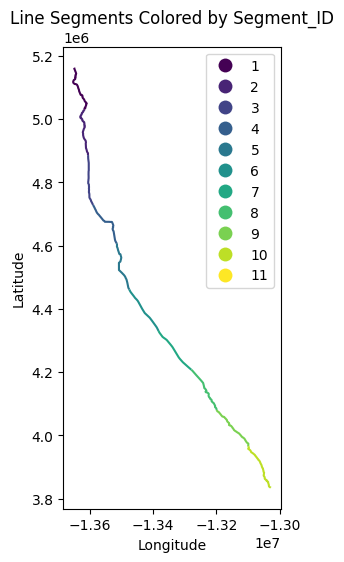

In [13]:
#Splitting the I5 into 10 segments of equal length

# Plot the GeoDataFrame colored by Segment_ID
ax = segment_gdf.plot(column='Segment_ID', cmap='viridis', legend=True, figsize=(10, 6), categorical=True)

# Optional: Add a title and axis labels
ax.set_title('Line Segments Colored by Segment_ID')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


In [14]:
#Armonizing the Coordinate Reference System
target_crs = ca_map.crs

In [15]:
lmp_map = lmp_map.set_crs("EPSG:4326")
lmp_map = lmp_map.to_crs(target_crs)

In [16]:
lmp_ca_map = gpd.sjoin(lmp_map, ca_map, how="inner", predicate="within") #Filterind nodes within CA

<Axes: >

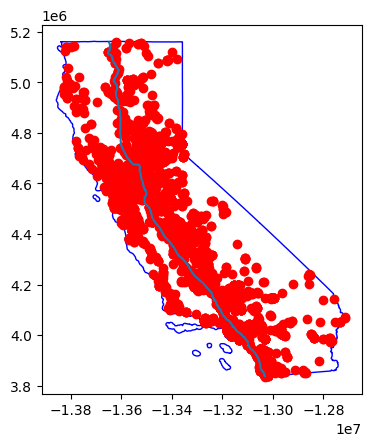

In [25]:
#Plotting the nodes and I5
base = ca_map.plot(color='white', edgecolor='b')
segment_gdf.plot(ax=base)
lmp_ca_map.plot(ax=base, color='red')

In [23]:
#Identifying nodes near I5
threshold = 8000  # distance threshold in the meters = 5 miles
lmp_map['within_threshold'] = lmp_map.geometry.apply(
    lambda point: segment_gdf.distance(point).min() <= threshold
)

# Filter and plot points within the threshold
lmp_i5_map = lmp_map[lmp_map['within_threshold']]


<Axes: >

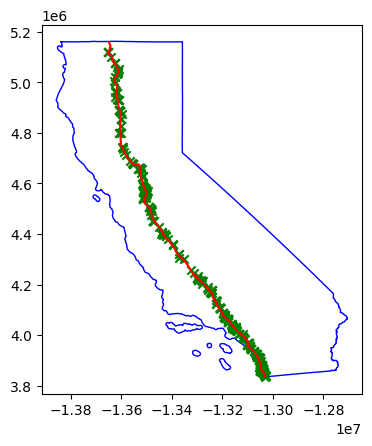

In [26]:
#Plotting only the nodes near the I5
base = ca_map.plot(color='white', edgecolor='b')
lmp_i5_map.plot(ax=base, color='green', marker="x")
I5_map.plot(ax=base, color="red")

In [28]:
#Identifying unique nodes
nodes_LMP = lmp_i5_map['AREA'].unique().tolist()
len(nodes_LMP)

405

In [29]:
#Filtering nodes that has no '#' in its name as it generate errors

nodes_to_get = [node for node in nodes_LMP if '#' not in node]

In [43]:
#Exporting nodes information
nodes_df = nodes_all_df[nodes_all_df['node_id'].isin(nodes_to_get)]
nodes_df.to_csv('nodes_i5-short.csv', index=False)

### Assign the closest segment to nodes

In [33]:
# Find closest road segment for each node
def find_closest_segment(node, segments):
    distances = segments.distance(node)
    min_idx = distances.idxmin()
    return segments.loc[min_idx, 'Segment_ID']

lmp_i5_map['closest_segment'] = lmp_i5_map['geometry'].apply(find_closest_segment, segments=segment_gdf)

node_segment_df = lmp_i5_map[['AREA', 'closest_segment']]

segment_counts = node_segment_df.groupby('closest_segment').size().reset_index(name='node_count')



/Users/jclopezr/myenv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [34]:
lmp_i5_map['closest_segment'] = lmp_i5_map.closest_segment.astype('category')

/Users/jclopezr/myenv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### exploring assigned segments and nodes

/var/folders/tl/qf20ky0x4fn57y_vpkmd8q600000gn/T/ipykernel_83486/230912627.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')  # High-contrast colormap


<Figure size 3600x3000 with 0 Axes>

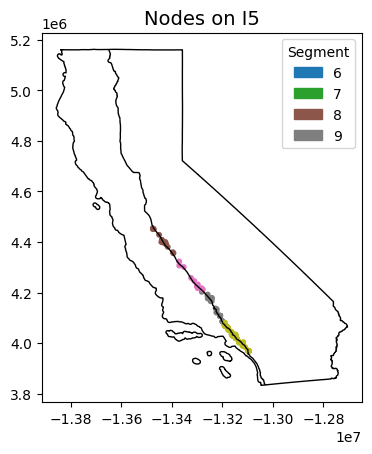

In [37]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Filter for segments 6 to 9
filtered_map = lmp_i5_map[lmp_i5_map['closest_segment'].isin([6, 7, 8, 9])] #Filtering for nodes 6 to 9

plt.figure(dpi=300, figsize=(12, 10))
base = ca_map.plot(color='white', edgecolor='black')

segment_gdf.plot(ax=base, color='black', linewidth=1, label='Segments')

cmap = plt.cm.get_cmap('tab10')  # High-contrast colormap
categories = filtered_map['closest_segment'].cat.categories
filtered_categories = [cat for cat in categories if cat in [6, 7, 8, 9]]  # Ensure only filtered segments
colors = [cmap(i / len(filtered_categories)) for i in range(len(categories))]
norm = mcolors.BoundaryNorm(range(len(categories) + 1), cmap.N)

# Add scatter plot for nodes
scatter = filtered_map.plot(#lmp_i5_map.plot(
    ax=base,
    column='closest_segment',
    cmap='tab10',
    legend=False,
    markersize=10,
    label='Nodes'
)

patches = [mpatches.Patch(color=colors[i], label=f'{cat}') for i, cat in enumerate(filtered_categories)]
plt.legend(handles=patches, title='Segment', loc='upper right', fontsize=10)

plt.title("Nodes on I5", fontsize=14)
plt.show()

In [40]:
node_segment_df.rename(columns={'AREA': 'node_id'}, inplace=True)

/var/folders/tl/qf20ky0x4fn57y_vpkmd8q600000gn/T/ipykernel_83486/3506955895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_segment_df.rename(columns={'AREA': 'node_id'}, inplace=True)


In [32]:
#Exporting dataset of nodes per segment
node_segment_df.to_csv('Data/node_segment.csv', index=False) 

## Gathering data from GRIDSTATUS (casio)

In [18]:
import gridstatus
import plotly.express as px
from datetime import datetime, timedelta

In [20]:
caiso = gridstatus.CAISO()

In [22]:
start = pd.Timestamp("Jan 1, 2022").normalize() #CAISO only provides 39 months of data
end = pd.Timestamp("Nov 11, 2024").normalize()
#end = pd.Timestamp("Nov 11,2024").normalize()
yesterday= pd.Timestamp(end-timedelta(hours=1)).normalize()

### collecting LMP 

In [ ]:
lmp_results = pd.DataFrame()

# Loop over nodes_to_get in batches of 400
for node in nodes_to_get:

    # Fetch data for the current batch
    node_result = caiso.get_lmp(start=start, end=end, market="REAL_TIME_15_MIN", locations=[node])

    #time.sleep(3)
    
    # Append the result to the list of all results
    lmp_results = pd.concat([lmp_results, node_result], ignore_index=True)

  1%|▊                                                                          | 276/25080 [24:31<33:59:04,  4.93s/it]

No data for 2022-01-12 11:00:00-08:00 to 2022-01-12 12:00:00-08:00
Error: No data found for start date: 2022-01-12 11:00:00-08:00 and end date: 2022-01-12 12:00:00-08:00
Args: {'self': <gridstatus.caiso.CAISO object at 0x00000234065BDC50>, 'date': Timestamp('2022-01-12 11:00:00-0800', tz='US/Pacific'), 'market': <Markets.REAL_TIME_15_MIN: 'REAL_TIME_15_MIN'>, 'locations': 'ALL', 'sleep': 3, 'end': Timestamp('2022-01-12 12:00:00-0800', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 11%|████████                                                                | 2825/25080 [4:12:46<31:32:44,  5.10s/it]

No data for 2022-04-28 17:00:00-07:00 to 2022-04-28 18:00:00-07:00
Error: No data found for start date: 2022-04-28 17:00:00-07:00 and end date: 2022-04-28 18:00:00-07:00
Args: {'self': <gridstatus.caiso.CAISO object at 0x00000234065BDC50>, 'date': Timestamp('2022-04-28 17:00:00-0700', tz='US/Pacific'), 'market': <Markets.REAL_TIME_15_MIN: 'REAL_TIME_15_MIN'>, 'locations': 'ALL', 'sleep': 3, 'end': Timestamp('2022-04-28 18:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 28%|███████████████████▊                                                   | 7004/25080 [11:49:25<55:58:29, 11.15s/it]

Error: HTTPConnectionPool(host='oasis.caiso.com', port=80): Max retries exceeded with url: /oasisapi/SingleZip?resultformat=6&queryname=PRC_RTPD_LMP&version=3&market_run_id=RTPD&grp_type=ALL&startdatetime=20221020T03:00-0000&enddatetime=20221020T04:00-0000 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000240B8DAF490>, 'Connection to oasis.caiso.com timed out. (connect timeout=None)'))
Args: {'self': <gridstatus.caiso.CAISO object at 0x00000234065BDC50>, 'dataset': 'lmp_real_time_15_min', 'params': {'grp_type': 'ALL'}, 'sleep': 3, 'raw_data': False, 'verbose': False, 'date': Timestamp('2022-10-19 20:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2022-10-19 21:00:00-0700', tz='US/Pacific')}

Errors that occurred while getting data:
[{'dataset': 'lmp_real_time_15_min',
  'date': Timestamp('2022-10-19 20:00:00-0700', tz='US/Pacific'),
  'end': Timestamp('2022-10-19 21:00:00-0700', tz='US/Pacific'),
  'params': {'grp_type': 'ALL'},
  'raw_data': False,
  

 35%|████████████████████████▉                                              | 8797/25080 [15:12:39<36:55:13,  8.16s/it]

In [ ]:
#Exporting LMP
lmp_results.to_csv("LMP_data_full.csv")

### collecting Grid mix 

In [24]:
#Getting grid mix
mix_df = caiso.get_fuel_mix(start, end=end, verbose=False) #Grid electricity mix

100%|███████████████████████████████████████| 1045/1045 [04:29<00:00,  3.88it/s]


In [26]:
#Exporting grid mix
mix_df.to_csv('grid_mix.csv', index=False)

### collecting Load

In [27]:
#Getting load
load_df = caiso.get_load(start, end=end) #Historical 

100%|███████████████████████████████████████| 1045/1045 [04:35<00:00,  3.79it/s]


In [29]:
#Exporting load
load_df.to_csv('load.csv', index=False)

### collecting gas price

In [30]:
#Getting gas princing data
gas_price_df = caiso.get_gas_prices(start=start, end=end, fuel_region_id="ALL") #Fuel prices - I need to get the fuel regions

 12%|█████▏                                      | 4/34 [00:29<03:22,  6.77s/it]

No data for 2022-04-04 01:00:00-07:00 to 2022-05-05 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2022-04-04 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2022-05-05 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 15%|██████▍                                     | 5/34 [00:37<03:32,  7.32s/it]

No data for 2022-05-05 01:00:00-07:00 to 2022-06-05 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2022-05-05 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2022-06-05 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 18%|███████▊                                    | 6/34 [00:45<03:35,  7.69s/it]

No data for 2022-06-05 01:00:00-07:00 to 2022-07-06 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2022-06-05 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2022-07-06 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 21%|█████████                                   | 7/34 [00:54<03:33,  7.91s/it]

No data for 2022-07-06 01:00:00-07:00 to 2022-08-06 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2022-07-06 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2022-08-06 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 24%|██████████▎                                 | 8/34 [01:02<03:30,  8.08s/it]

No data for 2022-08-06 01:00:00-07:00 to 2022-09-06 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2022-08-06 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2022-09-06 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 26%|███████████▋                                | 9/34 [01:11<03:23,  8.16s/it]

No data for 2022-09-06 01:00:00-07:00 to 2022-10-07 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2022-09-06 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2022-10-07 01:00:00-0700', tz='US/Pacific')}



 47%|████████████████████▏                      | 16/34 [02:05<02:09,  7.18s/it]

No data for 2023-04-11 01:00:00-07:00 to 2023-05-12 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2023-04-11 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2023-05-12 01:00:00-0700', tz='US/Pacific')}



 50%|█████████████████████▌                     | 17/34 [02:09<01:46,  6.27s/it]

No data for 2023-05-12 01:00:00-07:00 to 2023-06-12 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2023-05-12 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2023-06-12 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 53%|██████████████████████▊                    | 18/34 [02:17<01:50,  6.90s/it]

No data for 2023-06-12 01:00:00-07:00 to 2023-07-13 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2023-06-12 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2023-07-13 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 56%|████████████████████████                   | 19/34 [02:26<01:50,  7.36s/it]

No data for 2023-07-13 01:00:00-07:00 to 2023-08-13 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2023-07-13 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2023-08-13 01:00:00-0700', tz='US/Pacific')}



 59%|█████████████████████████▎                 | 20/34 [02:30<01:29,  6.40s/it]

No data for 2023-08-13 01:00:00-07:00 to 2023-09-13 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2023-08-13 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2023-09-13 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 62%|██████████████████████████▌                | 21/34 [02:38<01:30,  7.00s/it]

No data for 2023-09-13 01:00:00-07:00 to 2023-10-14 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2023-09-13 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2023-10-14 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 79%|██████████████████████████████████▏        | 27/34 [03:31<00:52,  7.49s/it]

No data for 2024-03-17 01:00:00-07:00 to 2024-04-17 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2024-03-17 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2024-04-17 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 82%|███████████████████████████████████▍       | 28/34 [03:39<00:46,  7.71s/it]

No data for 2024-04-17 01:00:00-07:00 to 2024-05-18 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2024-04-17 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2024-05-18 01:00:00-0700', tz='US/Pacific')}



 85%|████████████████████████████████████▋      | 29/34 [03:44<00:33,  6.65s/it]

No data for 2024-05-18 01:00:00-07:00 to 2024-06-18 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2024-05-18 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2024-06-18 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 88%|█████████████████████████████████████▉     | 30/34 [03:52<00:28,  7.16s/it]

No data for 2024-06-18 01:00:00-07:00 to 2024-07-19 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2024-06-18 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2024-07-19 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 91%|███████████████████████████████████████▏   | 31/34 [04:00<00:22,  7.53s/it]

No data for 2024-07-19 01:00:00-07:00 to 2024-08-19 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2024-07-19 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2024-08-19 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 94%|████████████████████████████████████████▍  | 32/34 [04:09<00:15,  7.79s/it]

No data for 2024-08-19 01:00:00-07:00 to 2024-09-19 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2024-08-19 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2024-09-19 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


 97%|█████████████████████████████████████████▋ | 33/34 [04:17<00:07,  7.98s/it]

No data for 2024-09-19 01:00:00-07:00 to 2024-10-20 01:00:00-07:00
Error: 'Time'
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'fuel_region_id': 'ALL', 'date': Timestamp('2024-09-19 01:00:00-0700', tz='US/Pacific'), 'end': Timestamp('2024-10-20 01:00:00-0700', tz='US/Pacific')}

Failed to get data from CAISO. Error: 429
Retrying 1...


100%|███████████████████████████████████████████| 34/34 [04:29<00:00,  7.92s/it]

Errors that occurred while getting data:
[{'date': Timestamp('2022-04-04 01:00:00-0700', tz='US/Pacific'),
  'end': Timestamp('2022-05-05 01:00:00-0700', tz='US/Pacific'),
  'fuel_region_id': 'ALL',
  'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>},
 {'date': Timestamp('2022-05-05 01:00:00-0700', tz='US/Pacific'),
  'end': Timestamp('2022-06-05 01:00:00-0700', tz='US/Pacific'),
  'fuel_region_id': 'ALL',
  'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>},
 {'date': Timestamp('2022-06-05 01:00:00-0700', tz='US/Pacific'),
  'end': Timestamp('2022-07-06 01:00:00-0700', tz='US/Pacific'),
  'fuel_region_id': 'ALL',
  'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>},
 {'date': Timestamp('2022-07-06 01:00:00-0700', tz='US/Pacific'),
  'end': Timestamp('2022-08-06 01:00:00-0700', tz='US/Pacific'),
  'fuel_region_id': 'ALL',
  'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>},
 {'date': Timestamp('2022-08-06 01:00:00-0700', tz='US/Pacific'),
  'end': Timestamp('2022-

In [31]:
#Exporting gas price data
gas_price_df.to_csv('gas_price.csv', index=False)

### collecting storage

In [34]:
#Getting storage date
storage_df = caiso.get_storage(start=start, end=end) #Storage available

  0%|                                          | 1/1045 [00:00<07:18,  2.38it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-01 00:00:00-0800', tz='US/Pacific')}



  0%|                                          | 3/1045 [00:00<04:37,  3.75it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-02 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-03 00:00:00-0800', tz='US/Pacific')}



  0%|▏                                         | 4/1045 [00:01<04:26,  3.90it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-04 00:00:00-0800', tz='US/Pacific')}



  0%|▏                                         | 5/1045 [00:01<04:36,  3.76it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-05 00:00:00-0800', tz='US/Pacific')}



  1%|▏                                         | 6/1045 [00:01<04:32,  3.82it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-06 00:00:00-0800', tz='US/Pacific')}



  1%|▎                                         | 7/1045 [00:01<04:29,  3.85it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-07 00:00:00-0800', tz='US/Pacific')}



  1%|▎                                         | 8/1045 [00:02<04:33,  3.79it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-08 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-09 00:00:00-0800', tz='US/Pacific')}



  1%|▍                                        | 10/1045 [00:02<04:34,  3.77it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-10 00:00:00-0800', tz='US/Pacific')}



  1%|▍                                        | 11/1045 [00:02<04:29,  3.84it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-11 00:00:00-0800', tz='US/Pacific')}



  1%|▍                                        | 12/1045 [00:03<04:33,  3.78it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-12 00:00:00-0800', tz='US/Pacific')}



  1%|▌                                        | 13/1045 [00:03<04:30,  3.81it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-13 00:00:00-0800', tz='US/Pacific')}



  1%|▌                                        | 15/1045 [00:03<03:54,  4.40it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-14 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-15 00:00:00-0800', tz='US/Pacific')}



  2%|▋                                        | 16/1045 [00:04<04:41,  3.66it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-16 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-17 00:00:00-0800', tz='US/Pacific')}



  2%|▋                                        | 18/1045 [00:04<04:41,  3.65it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-18 00:00:00-0800', tz='US/Pacific')}



  2%|▋                                        | 19/1045 [00:05<04:21,  3.93it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-19 00:00:00-0800', tz='US/Pacific')}



  2%|▊                                        | 20/1045 [00:05<04:39,  3.67it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-20 00:00:00-0800', tz='US/Pacific')}



  2%|▊                                        | 21/1045 [00:05<04:37,  3.69it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-21 00:00:00-0800', tz='US/Pacific')}



  2%|▉                                        | 23/1045 [00:06<03:57,  4.31it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-22 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-23 00:00:00-0800', tz='US/Pacific')}



  2%|▉                                        | 24/1045 [00:06<03:49,  4.45it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-24 00:00:00-0800', tz='US/Pacific')}



  2%|▉                                        | 25/1045 [00:06<04:29,  3.79it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-25 00:00:00-0800', tz='US/Pacific')}



  2%|█                                        | 26/1045 [00:06<04:49,  3.52it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-26 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-27 00:00:00-0800', tz='US/Pacific')}



  3%|█                                        | 28/1045 [00:07<03:41,  4.59it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-28 00:00:00-0800', tz='US/Pacific')}



  3%|█▏                                       | 29/1045 [00:07<04:03,  4.17it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-29 00:00:00-0800', tz='US/Pacific')}



  3%|█▏                                       | 30/1045 [00:07<04:00,  4.21it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-30 00:00:00-0800', tz='US/Pacific')}



  3%|█▏                                       | 31/1045 [00:08<04:39,  3.62it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-01-31 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-01 00:00:00-0800', tz='US/Pacific')}



  3%|█▎                                       | 33/1045 [00:08<04:40,  3.61it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-02 00:00:00-0800', tz='US/Pacific')}



  3%|█▎                                       | 34/1045 [00:09<05:04,  3.32it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-03 00:00:00-0800', tz='US/Pacific')}



  3%|█▎                                       | 35/1045 [00:09<04:50,  3.47it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-04 00:00:00-0800', tz='US/Pacific')}



  4%|█▍                                       | 37/1045 [00:09<04:17,  3.91it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-05 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-06 00:00:00-0800', tz='US/Pacific')}



  4%|█▍                                       | 38/1045 [00:10<04:41,  3.57it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-07 00:00:00-0800', tz='US/Pacific')}



  4%|█▌                                       | 40/1045 [00:10<03:45,  4.45it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-08 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-09 00:00:00-0800', tz='US/Pacific')}



  4%|█▋                                       | 42/1045 [00:10<03:37,  4.61it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-10 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-11 00:00:00-0800', tz='US/Pacific')}



  4%|█▋                                       | 44/1045 [00:11<03:19,  5.01it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-12 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-13 00:00:00-0800', tz='US/Pacific')}



  4%|█▊                                       | 45/1045 [00:11<03:09,  5.28it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-14 00:00:00-0800', tz='US/Pacific')}



  4%|█▊                                       | 46/1045 [00:11<03:59,  4.18it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-15 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-16 00:00:00-0800', tz='US/Pacific')}



  5%|█▉                                       | 49/1045 [00:12<03:30,  4.73it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-17 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-18 00:00:00-0800', tz='US/Pacific')}



  5%|██                                       | 51/1045 [00:12<03:38,  4.55it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-19 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-20 00:00:00-0800', tz='US/Pacific')}



  5%|██                                       | 52/1045 [00:13<04:09,  3.98it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-21 00:00:00-0800', tz='US/Pacific')}



  5%|██                                       | 53/1045 [00:13<04:15,  3.88it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-22 00:00:00-0800', tz='US/Pacific')}



  5%|██                                       | 54/1045 [00:13<04:12,  3.92it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-23 00:00:00-0800', tz='US/Pacific')}



  5%|██▏                                      | 55/1045 [00:13<04:14,  3.89it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-24 00:00:00-0800', tz='US/Pacific')}



  5%|██▏                                      | 57/1045 [00:14<03:57,  4.16it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-25 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-26 00:00:00-0800', tz='US/Pacific')}



  6%|██▎                                      | 58/1045 [00:14<04:26,  3.71it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-27 00:00:00-0800', tz='US/Pacific')}



  6%|██▎                                      | 59/1045 [00:15<04:11,  3.93it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-02-28 00:00:00-0800', tz='US/Pacific')}



  6%|██▍                                      | 61/1045 [00:15<03:41,  4.45it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-01 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-02 00:00:00-0800', tz='US/Pacific')}



  6%|██▍                                      | 62/1045 [00:15<04:32,  3.60it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-03 00:00:00-0800', tz='US/Pacific')}



  6%|██▍                                      | 63/1045 [00:16<04:40,  3.50it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-04 00:00:00-0800', tz='US/Pacific')}



  6%|██▌                                      | 64/1045 [00:16<05:41,  2.87it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-05 00:00:00-0800', tz='US/Pacific')}



  6%|██▌                                      | 65/1045 [00:16<05:11,  3.14it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-06 00:00:00-0800', tz='US/Pacific')}



  6%|██▌                                      | 66/1045 [00:17<04:54,  3.33it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-07 00:00:00-0800', tz='US/Pacific')}



  6%|██▋                                      | 67/1045 [00:17<04:44,  3.43it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-08 00:00:00-0800', tz='US/Pacific')}



  7%|██▋                                      | 68/1045 [00:17<04:23,  3.71it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-09 00:00:00-0800', tz='US/Pacific')}



  7%|██▋                                      | 69/1045 [00:17<04:32,  3.58it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-10 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-11 00:00:00-0800', tz='US/Pacific')}



  7%|██▊                                      | 72/1045 [00:18<03:44,  4.33it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-12 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-13 00:00:00-0800', tz='US/Pacific')}



  7%|██▊                                      | 73/1045 [00:18<03:38,  4.46it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-14 00:00:00-0700', tz='US/Pacific')}



  7%|██▉                                      | 74/1045 [00:19<04:12,  3.84it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-15 00:00:00-0700', tz='US/Pacific')}



  7%|██▉                                      | 75/1045 [00:19<03:58,  4.07it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-16 00:00:00-0700', tz='US/Pacific')}



  7%|██▉                                      | 76/1045 [00:19<03:55,  4.12it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-17 00:00:00-0700', tz='US/Pacific')}



  7%|███                                      | 77/1045 [00:19<03:53,  4.14it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-18 00:00:00-0700', tz='US/Pacific')}



  8%|███                                      | 79/1045 [00:20<04:03,  3.97it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-19 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-20 00:00:00-0700', tz='US/Pacific')}



  8%|███▏                                     | 80/1045 [00:20<04:40,  3.44it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-21 00:00:00-0700', tz='US/Pacific')}



  8%|███▏                                     | 82/1045 [00:21<04:13,  3.80it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-22 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-23 00:00:00-0700', tz='US/Pacific')}



  8%|███▎                                     | 83/1045 [00:21<04:35,  3.49it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-24 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-25 00:00:00-0700', tz='US/Pacific')}



  8%|███▎                                     | 85/1045 [00:22<04:28,  3.57it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-26 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-27 00:00:00-0700', tz='US/Pacific')}



  8%|███▍                                     | 87/1045 [00:22<04:24,  3.63it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-28 00:00:00-0700', tz='US/Pacific')}



  8%|███▍                                     | 88/1045 [00:22<04:15,  3.74it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-29 00:00:00-0700', tz='US/Pacific')}



  9%|███▍                                     | 89/1045 [00:23<04:19,  3.69it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-30 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-03-31 00:00:00-0700', tz='US/Pacific')}



  9%|███▌                                     | 91/1045 [00:23<04:20,  3.66it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-01 00:00:00-0700', tz='US/Pacific')}



  9%|███▌                                     | 92/1045 [00:23<04:12,  3.78it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-02 00:00:00-0700', tz='US/Pacific')}



  9%|███▋                                     | 93/1045 [00:24<04:15,  3.73it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-03 00:00:00-0700', tz='US/Pacific')}



  9%|███▋                                     | 94/1045 [00:24<04:05,  3.87it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-04 00:00:00-0700', tz='US/Pacific')}



  9%|███▋                                     | 95/1045 [00:24<04:12,  3.77it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-05 00:00:00-0700', tz='US/Pacific')}



  9%|███▊                                     | 96/1045 [00:24<04:02,  3.91it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-06 00:00:00-0700', tz='US/Pacific')}



  9%|███▊                                     | 97/1045 [00:25<04:20,  3.64it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-07 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-08 00:00:00-0700', tz='US/Pacific')}



  9%|███▉                                     | 99/1045 [00:25<04:12,  3.75it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-09 00:00:00-0700', tz='US/Pacific')}



 10%|███▊                                    | 101/1045 [00:26<03:24,  4.61it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-10 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-11 00:00:00-0700', tz='US/Pacific')}



 10%|███▉                                    | 102/1045 [00:26<04:02,  3.89it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-12 00:00:00-0700', tz='US/Pacific')}



 10%|███▉                                    | 103/1045 [00:26<04:24,  3.56it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-13 00:00:00-0700', tz='US/Pacific')}



 10%|███▉                                    | 104/1045 [00:27<04:04,  3.85it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-14 00:00:00-0700', tz='US/Pacific')}



 10%|████                                    | 106/1045 [00:27<03:38,  4.30it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-15 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-16 00:00:00-0700', tz='US/Pacific')}



 10%|████                                    | 107/1045 [00:27<03:12,  4.88it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-17 00:00:00-0700', tz='US/Pacific')}



 10%|████▏                                   | 108/1045 [00:27<03:25,  4.56it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-18 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-19 00:00:00-0700', tz='US/Pacific')}



 11%|████▏                                   | 111/1045 [00:28<03:16,  4.75it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-20 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-21 00:00:00-0700', tz='US/Pacific')}



 11%|████▎                                   | 112/1045 [00:28<03:13,  4.83it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-22 00:00:00-0700', tz='US/Pacific')}



 11%|████▎                                   | 113/1045 [00:29<03:59,  3.89it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-23 00:00:00-0700', tz='US/Pacific')}



 11%|████▎                                   | 114/1045 [00:29<04:24,  3.52it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-24 00:00:00-0700', tz='US/Pacific')}



 11%|████▍                                   | 115/1045 [00:29<04:05,  3.78it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-25 00:00:00-0700', tz='US/Pacific')}



 11%|████▍                                   | 117/1045 [00:30<03:43,  4.16it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-26 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-27 00:00:00-0700', tz='US/Pacific')}



 11%|████▌                                   | 118/1045 [00:30<04:19,  3.58it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-28 00:00:00-0700', tz='US/Pacific')}



 11%|████▌                                   | 119/1045 [00:30<04:01,  3.84it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-29 00:00:00-0700', tz='US/Pacific')}



 11%|████▌                                   | 120/1045 [00:31<04:14,  3.64it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-04-30 00:00:00-0700', tz='US/Pacific')}



 12%|████▋                                   | 121/1045 [00:31<03:59,  3.85it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-01 00:00:00-0700', tz='US/Pacific')}



 12%|████▋                                   | 123/1045 [00:31<03:31,  4.37it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-02 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-03 00:00:00-0700', tz='US/Pacific')}



 12%|████▋                                   | 124/1045 [00:31<03:01,  5.07it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-04 00:00:00-0700', tz='US/Pacific')}



 12%|████▊                                   | 125/1045 [00:32<03:21,  4.56it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-05 00:00:00-0700', tz='US/Pacific')}



 12%|████▊                                   | 126/1045 [00:32<03:19,  4.60it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-06 00:00:00-0700', tz='US/Pacific')}



 12%|████▉                                   | 128/1045 [00:32<03:16,  4.66it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-07 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-08 00:00:00-0700', tz='US/Pacific')}



 12%|████▉                                   | 129/1045 [00:33<04:08,  3.69it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-09 00:00:00-0700', tz='US/Pacific')}



 12%|████▉                                   | 130/1045 [00:33<03:53,  3.92it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-10 00:00:00-0700', tz='US/Pacific')}



 13%|█████                                   | 132/1045 [00:33<03:41,  4.13it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-11 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-12 00:00:00-0700', tz='US/Pacific')}



 13%|█████                                   | 133/1045 [00:34<04:03,  3.74it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-13 00:00:00-0700', tz='US/Pacific')}



 13%|█████▏                                  | 134/1045 [00:34<04:04,  3.72it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-14 00:00:00-0700', tz='US/Pacific')}



 13%|█████▏                                  | 135/1045 [00:34<04:07,  3.67it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-15 00:00:00-0700', tz='US/Pacific')}



 13%|█████▏                                  | 136/1045 [00:34<03:54,  3.87it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-16 00:00:00-0700', tz='US/Pacific')}



 13%|█████▏                                  | 137/1045 [00:35<04:01,  3.76it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-17 00:00:00-0700', tz='US/Pacific')}



 13%|█████▎                                  | 138/1045 [00:35<03:53,  3.88it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-18 00:00:00-0700', tz='US/Pacific')}



 13%|█████▎                                  | 139/1045 [00:35<04:00,  3.77it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-19 00:00:00-0700', tz='US/Pacific')}



 13%|█████▎                                  | 140/1045 [00:35<03:46,  4.00it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-20 00:00:00-0700', tz='US/Pacific')}



 14%|█████▍                                  | 142/1045 [00:36<03:42,  4.05it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-21 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-22 00:00:00-0700', tz='US/Pacific')}



 14%|█████▌                                  | 144/1045 [00:36<03:24,  4.40it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-23 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-24 00:00:00-0700', tz='US/Pacific')}



 14%|█████▌                                  | 145/1045 [00:37<03:18,  4.53it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-25 00:00:00-0700', tz='US/Pacific')}



 14%|█████▌                                  | 146/1045 [00:37<03:57,  3.78it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-26 00:00:00-0700', tz='US/Pacific')}



 14%|█████▋                                  | 148/1045 [00:38<03:55,  3.82it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-27 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-28 00:00:00-0700', tz='US/Pacific')}



 14%|█████▋                                  | 150/1045 [00:38<03:29,  4.26it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-29 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-30 00:00:00-0700', tz='US/Pacific')}



 14%|█████▊                                  | 151/1045 [00:38<03:26,  4.32it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-05-31 00:00:00-0700', tz='US/Pacific')}



 15%|█████▊                                  | 152/1045 [00:39<04:02,  3.68it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-01 00:00:00-0700', tz='US/Pacific')}



 15%|█████▉                                  | 154/1045 [00:39<03:55,  3.79it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-02 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-03 00:00:00-0700', tz='US/Pacific')}



 15%|█████▉                                  | 156/1045 [00:40<03:26,  4.31it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-04 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-05 00:00:00-0700', tz='US/Pacific')}



 15%|██████                                  | 158/1045 [00:40<03:28,  4.26it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-06 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-07 00:00:00-0700', tz='US/Pacific')}



 15%|██████                                  | 159/1045 [00:40<03:29,  4.23it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-08 00:00:00-0700', tz='US/Pacific')}



 15%|██████                                  | 160/1045 [00:41<03:34,  4.12it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-09 00:00:00-0700', tz='US/Pacific')}



 15%|██████▏                                 | 161/1045 [00:41<03:33,  4.15it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-10 00:00:00-0700', tz='US/Pacific')}



 16%|██████▏                                 | 162/1045 [00:41<04:12,  3.49it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-11 00:00:00-0700', tz='US/Pacific')}



 16%|██████▎                                 | 164/1045 [00:42<03:55,  3.73it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-12 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-13 00:00:00-0700', tz='US/Pacific')}



 16%|██████▎                                 | 165/1045 [00:42<03:29,  4.20it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-14 00:00:00-0700', tz='US/Pacific')}



 16%|██████▎                                 | 166/1045 [00:42<03:55,  3.73it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-15 00:00:00-0700', tz='US/Pacific')}



 16%|██████▍                                 | 167/1045 [00:43<04:16,  3.42it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-16 00:00:00-0700', tz='US/Pacific')}



 16%|██████▍                                 | 168/1045 [00:43<03:55,  3.73it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-17 00:00:00-0700', tz='US/Pacific')}



 16%|██████▌                                 | 170/1045 [00:43<03:44,  3.90it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-18 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-19 00:00:00-0700', tz='US/Pacific')}



 16%|██████▌                                 | 171/1045 [00:44<04:02,  3.60it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-20 00:00:00-0700', tz='US/Pacific')}



 16%|██████▌                                 | 172/1045 [00:44<03:51,  3.77it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-21 00:00:00-0700', tz='US/Pacific')}



 17%|██████▌                                 | 173/1045 [00:44<03:55,  3.70it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-22 00:00:00-0700', tz='US/Pacific')}



 17%|██████▋                                 | 174/1045 [00:44<03:48,  3.81it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-23 00:00:00-0700', tz='US/Pacific')}



 17%|██████▋                                 | 175/1045 [00:45<03:53,  3.73it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-24 00:00:00-0700', tz='US/Pacific')}



 17%|██████▋                                 | 176/1045 [00:45<03:41,  3.93it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-25 00:00:00-0700', tz='US/Pacific')}



 17%|██████▊                                 | 177/1045 [00:45<03:53,  3.72it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-26 00:00:00-0700', tz='US/Pacific')}



 17%|██████▊                                 | 178/1045 [00:45<03:42,  3.90it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-27 00:00:00-0700', tz='US/Pacific')}



 17%|██████▊                                 | 179/1045 [00:46<03:53,  3.71it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-28 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-29 00:00:00-0700', tz='US/Pacific')}



 17%|██████▉                                 | 182/1045 [00:46<03:30,  4.10it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-06-30 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-01 00:00:00-0700', tz='US/Pacific')}



 18%|███████                                 | 184/1045 [00:47<03:22,  4.25it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-02 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-03 00:00:00-0700', tz='US/Pacific')}



 18%|███████                                 | 186/1045 [00:48<03:36,  3.98it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-04 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-05 00:00:00-0700', tz='US/Pacific')}



 18%|███████▏                                | 188/1045 [00:48<03:32,  4.04it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-06 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-07 00:00:00-0700', tz='US/Pacific')}



 18%|███████▏                                | 189/1045 [00:48<03:54,  3.64it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-08 00:00:00-0700', tz='US/Pacific')}



 18%|███████▎                                | 190/1045 [00:49<04:04,  3.50it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-09 00:00:00-0700', tz='US/Pacific')}



 18%|███████▎                                | 192/1045 [00:49<03:15,  4.36it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-10 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-11 00:00:00-0700', tz='US/Pacific')}



 18%|███████▍                                | 193/1045 [00:49<03:08,  4.51it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-12 00:00:00-0700', tz='US/Pacific')}



 19%|███████▍                                | 194/1045 [00:50<03:35,  3.95it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-13 00:00:00-0700', tz='US/Pacific')}



 19%|███████▍                                | 195/1045 [00:50<04:04,  3.47it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-14 00:00:00-0700', tz='US/Pacific')}



 19%|███████▌                                | 196/1045 [00:50<03:49,  3.70it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-15 00:00:00-0700', tz='US/Pacific')}



 19%|███████▌                                | 197/1045 [00:50<03:54,  3.62it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-16 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-17 00:00:00-0700', tz='US/Pacific')}



 19%|███████▌                                | 199/1045 [00:51<03:53,  3.63it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-18 00:00:00-0700', tz='US/Pacific')}



 19%|███████▋                                | 200/1045 [00:51<03:45,  3.74it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-19 00:00:00-0700', tz='US/Pacific')}



 19%|███████▋                                | 201/1045 [00:52<03:47,  3.71it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-20 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-21 00:00:00-0700', tz='US/Pacific')}



 19%|███████▊                                | 203/1045 [00:52<03:47,  3.70it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-22 00:00:00-0700', tz='US/Pacific')}



 20%|███████▊                                | 204/1045 [00:52<03:36,  3.88it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-23 00:00:00-0700', tz='US/Pacific')}



 20%|███████▉                                | 206/1045 [00:53<03:11,  4.38it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-24 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-25 00:00:00-0700', tz='US/Pacific')}



 20%|███████▉                                | 207/1045 [00:53<02:52,  4.85it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-26 00:00:00-0700', tz='US/Pacific')}



 20%|███████▉                                | 208/1045 [00:53<02:59,  4.66it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-27 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-28 00:00:00-0700', tz='US/Pacific')}



 20%|████████                                | 210/1045 [00:54<03:27,  4.03it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-29 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-30 00:00:00-0700', tz='US/Pacific')}



 20%|████████▏                               | 213/1045 [00:54<03:19,  4.18it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-07-31 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-01 00:00:00-0700', tz='US/Pacific')}



 20%|████████▏                               | 214/1045 [00:55<03:39,  3.78it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-02 00:00:00-0700', tz='US/Pacific')}



 21%|████████▏                               | 215/1045 [00:55<03:37,  3.81it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-03 00:00:00-0700', tz='US/Pacific')}



 21%|████████▎                               | 216/1045 [00:55<03:38,  3.79it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-04 00:00:00-0700', tz='US/Pacific')}



 21%|████████▎                               | 217/1045 [00:55<03:26,  4.01it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-05 00:00:00-0700', tz='US/Pacific')}



 21%|████████▎                               | 218/1045 [00:56<03:40,  3.75it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-06 00:00:00-0700', tz='US/Pacific')}



 21%|████████▍                               | 219/1045 [00:56<03:35,  3.84it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-07 00:00:00-0700', tz='US/Pacific')}



 21%|████████▍                               | 221/1045 [00:56<03:04,  4.47it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-08 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-09 00:00:00-0700', tz='US/Pacific')}



 21%|████████▍                               | 222/1045 [00:56<02:45,  4.98it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-10 00:00:00-0700', tz='US/Pacific')}



 21%|████████▌                               | 224/1045 [00:57<02:52,  4.77it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-11 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-12 00:00:00-0700', tz='US/Pacific')}



 22%|████████▋                               | 226/1045 [00:57<03:07,  4.36it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-13 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-14 00:00:00-0700', tz='US/Pacific')}



 22%|████████▋                               | 227/1045 [00:58<03:31,  3.86it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-15 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-16 00:00:00-0700', tz='US/Pacific')}



 22%|████████▊                               | 229/1045 [00:58<03:43,  3.65it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-17 00:00:00-0700', tz='US/Pacific')}



 22%|████████▊                               | 230/1045 [00:59<03:37,  3.74it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-18 00:00:00-0700', tz='US/Pacific')}



 22%|████████▊                               | 231/1045 [00:59<03:33,  3.82it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-19 00:00:00-0700', tz='US/Pacific')}



 22%|████████▉                               | 232/1045 [00:59<03:24,  3.98it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-20 00:00:00-0700', tz='US/Pacific')}



 22%|████████▉                               | 233/1045 [00:59<03:36,  3.76it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-21 00:00:00-0700', tz='US/Pacific')}



 22%|████████▉                               | 234/1045 [01:00<03:28,  3.89it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-22 00:00:00-0700', tz='US/Pacific')}



 22%|████████▉                               | 235/1045 [01:00<03:35,  3.77it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-23 00:00:00-0700', tz='US/Pacific')}



 23%|█████████                               | 236/1045 [01:00<03:42,  3.63it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-24 00:00:00-0700', tz='US/Pacific')}



 23%|█████████                               | 237/1045 [01:00<03:29,  3.85it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-25 00:00:00-0700', tz='US/Pacific')}



 23%|█████████                               | 238/1045 [01:01<03:25,  3.92it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-26 00:00:00-0700', tz='US/Pacific')}



 23%|█████████▏                              | 239/1045 [01:01<03:33,  3.77it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-27 00:00:00-0700', tz='US/Pacific')}



 23%|█████████▏                              | 240/1045 [01:01<03:25,  3.91it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-28 00:00:00-0700', tz='US/Pacific')}



 23%|█████████▏                              | 241/1045 [01:01<03:35,  3.73it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-29 00:00:00-0700', tz='US/Pacific')}



 23%|█████████▎                              | 242/1045 [01:02<03:34,  3.74it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-30 00:00:00-0700', tz='US/Pacific')}



 23%|█████████▎                              | 244/1045 [01:02<03:18,  4.03it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-08-31 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-01 00:00:00-0700', tz='US/Pacific')}



 23%|█████████▍                              | 245/1045 [01:03<03:25,  3.90it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-02 00:00:00-0700', tz='US/Pacific')}



 24%|█████████▍                              | 246/1045 [01:03<03:32,  3.75it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-03 00:00:00-0700', tz='US/Pacific')}



 24%|█████████▍                              | 247/1045 [01:03<03:26,  3.86it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-04 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-05 00:00:00-0700', tz='US/Pacific')}



 24%|█████████▌                              | 249/1045 [01:04<03:32,  3.75it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-06 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-07 00:00:00-0700', tz='US/Pacific')}



 24%|█████████▋                              | 252/1045 [01:04<02:57,  4.46it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-08 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-09 00:00:00-0700', tz='US/Pacific')}



 24%|█████████▋                              | 253/1045 [01:04<02:50,  4.64it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-10 00:00:00-0700', tz='US/Pacific')}



 24%|█████████▋                              | 254/1045 [01:05<04:12,  3.13it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-11 00:00:00-0700', tz='US/Pacific')}



 24%|█████████▊                              | 255/1045 [01:05<04:16,  3.09it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-12 00:00:00-0700', tz='US/Pacific')}



 25%|█████████▊                              | 257/1045 [01:06<03:31,  3.72it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-13 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-14 00:00:00-0700', tz='US/Pacific')}



 25%|█████████▉                              | 258/1045 [01:06<03:02,  4.32it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-15 00:00:00-0700', tz='US/Pacific')}



 25%|█████████▉                              | 259/1045 [01:06<03:09,  4.14it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-16 00:00:00-0700', tz='US/Pacific')}



 25%|█████████▉                              | 260/1045 [01:06<03:07,  4.18it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-17 00:00:00-0700', tz='US/Pacific')}



 25%|█████████▉                              | 261/1045 [01:07<03:20,  3.91it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-18 00:00:00-0700', tz='US/Pacific')}



 25%|██████████                              | 262/1045 [01:07<03:21,  3.89it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-19 00:00:00-0700', tz='US/Pacific')}



 25%|██████████                              | 264/1045 [01:07<02:53,  4.51it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-20 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-21 00:00:00-0700', tz='US/Pacific')}



 25%|██████████▏                             | 265/1045 [01:08<02:51,  4.55it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-22 00:00:00-0700', tz='US/Pacific')}



 25%|██████████▏                             | 266/1045 [01:08<03:00,  4.33it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-23 00:00:00-0700', tz='US/Pacific')}



 26%|██████████▏                             | 267/1045 [01:09<06:46,  1.91it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-24 00:00:00-0700', tz='US/Pacific')}



 26%|██████████▎                             | 269/1045 [01:09<04:32,  2.84it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-25 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-26 00:00:00-0700', tz='US/Pacific')}



 26%|██████████▎                             | 270/1045 [01:10<04:02,  3.20it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-27 00:00:00-0700', tz='US/Pacific')}



 26%|██████████▎                             | 271/1045 [01:10<04:06,  3.14it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-28 00:00:00-0700', tz='US/Pacific')}



 26%|██████████▍                             | 273/1045 [01:11<03:29,  3.69it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-29 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-09-30 00:00:00-0700', tz='US/Pacific')}



 26%|██████████▍                             | 274/1045 [01:11<03:14,  3.96it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-01 00:00:00-0700', tz='US/Pacific')}



 26%|██████████▌                             | 275/1045 [01:11<03:40,  3.49it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-02 00:00:00-0700', tz='US/Pacific')}



 26%|██████████▌                             | 276/1045 [01:11<03:56,  3.26it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-03 00:00:00-0700', tz='US/Pacific')}



 27%|██████████▌                             | 277/1045 [01:12<03:36,  3.55it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-04 00:00:00-0700', tz='US/Pacific')}



 27%|██████████▋                             | 278/1045 [01:12<03:40,  3.47it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-05 00:00:00-0700', tz='US/Pacific')}



 27%|██████████▋                             | 279/1045 [01:12<03:24,  3.75it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-06 00:00:00-0700', tz='US/Pacific')}



 27%|██████████▋                             | 280/1045 [01:12<03:34,  3.56it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-07 00:00:00-0700', tz='US/Pacific')}



 27%|██████████▊                             | 281/1045 [01:13<03:23,  3.76it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-08 00:00:00-0700', tz='US/Pacific')}



 27%|██████████▊                             | 282/1045 [01:13<03:26,  3.69it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-09 00:00:00-0700', tz='US/Pacific')}



 27%|██████████▊                             | 283/1045 [01:13<03:14,  3.93it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-10 00:00:00-0700', tz='US/Pacific')}



 27%|██████████▊                             | 284/1045 [01:14<03:26,  3.69it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-11 00:00:00-0700', tz='US/Pacific')}



 27%|██████████▉                             | 285/1045 [01:14<03:12,  3.95it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-12 00:00:00-0700', tz='US/Pacific')}



 27%|██████████▉                             | 286/1045 [01:14<03:25,  3.69it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-13 00:00:00-0700', tz='US/Pacific')}



 27%|██████████▉                             | 287/1045 [01:14<03:15,  3.87it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-14 00:00:00-0700', tz='US/Pacific')}



 28%|███████████                             | 289/1045 [01:15<03:08,  4.01it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-15 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-16 00:00:00-0700', tz='US/Pacific')}



 28%|███████████                             | 290/1045 [01:15<02:42,  4.64it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-17 00:00:00-0700', tz='US/Pacific')}



 28%|███████████▏                            | 291/1045 [01:15<03:08,  4.01it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-18 00:00:00-0700', tz='US/Pacific')}



 28%|███████████▏                            | 292/1045 [01:16<03:37,  3.46it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-19 00:00:00-0700', tz='US/Pacific')}



 28%|███████████▏                            | 293/1045 [01:16<03:23,  3.69it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-20 00:00:00-0700', tz='US/Pacific')}



 28%|███████████▎                            | 295/1045 [01:16<03:10,  3.94it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-21 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-22 00:00:00-0700', tz='US/Pacific')}



 28%|███████████▎                            | 297/1045 [01:17<02:52,  4.33it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-23 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-24 00:00:00-0700', tz='US/Pacific')}



 29%|███████████▍                            | 298/1045 [01:17<02:50,  4.37it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-25 00:00:00-0700', tz='US/Pacific')}



 29%|███████████▍                            | 300/1045 [01:18<03:00,  4.13it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-26 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-27 00:00:00-0700', tz='US/Pacific')}



 29%|███████████▌                            | 301/1045 [01:18<03:18,  3.74it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-28 00:00:00-0700', tz='US/Pacific')}



 29%|███████████▌                            | 302/1045 [01:18<03:38,  3.40it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-29 00:00:00-0700', tz='US/Pacific')}



 29%|███████████▌                            | 303/1045 [01:18<03:24,  3.63it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-30 00:00:00-0700', tz='US/Pacific')}



 29%|███████████▋                            | 305/1045 [01:19<02:53,  4.27it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-10-31 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-01 00:00:00-0700', tz='US/Pacific')}



 29%|███████████▋                            | 306/1045 [01:19<02:45,  4.47it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-02 00:00:00-0700', tz='US/Pacific')}



 29%|███████████▊                            | 307/1045 [01:19<03:15,  3.77it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-03 00:00:00-0700', tz='US/Pacific')}



 29%|███████████▊                            | 308/1045 [01:20<03:37,  3.39it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-04 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-05 00:00:00-0700', tz='US/Pacific')}



 30%|███████████▊                            | 310/1045 [01:20<03:28,  3.53it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-06 00:00:00-0700', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-07 00:00:00-0800', tz='US/Pacific')}



 30%|███████████▉                            | 312/1045 [01:21<03:23,  3.60it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-08 00:00:00-0800', tz='US/Pacific')}



 30%|███████████▉                            | 313/1045 [01:21<03:13,  3.79it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-09 00:00:00-0800', tz='US/Pacific')}



 30%|████████████                            | 314/1045 [01:21<03:17,  3.69it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-10 00:00:00-0800', tz='US/Pacific')}



 30%|████████████                            | 316/1045 [01:22<02:42,  4.48it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-11 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-12 00:00:00-0800', tz='US/Pacific')}



 30%|████████████▏                           | 318/1045 [01:22<02:40,  4.52it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-13 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-14 00:00:00-0800', tz='US/Pacific')}



 31%|████████████▏                           | 319/1045 [01:23<03:19,  3.64it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-15 00:00:00-0800', tz='US/Pacific')}



 31%|████████████▏                           | 320/1045 [01:23<03:30,  3.44it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-16 00:00:00-0800', tz='US/Pacific')}



 31%|████████████▎                           | 321/1045 [01:23<03:23,  3.55it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-17 00:00:00-0800', tz='US/Pacific')}



 31%|████████████▎                           | 322/1045 [01:23<03:19,  3.62it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-18 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-19 00:00:00-0800', tz='US/Pacific')}



 31%|████████████▍                           | 324/1045 [01:24<02:44,  4.40it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-20 00:00:00-0800', tz='US/Pacific')}



 31%|████████████▍                           | 326/1045 [01:24<02:45,  4.35it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-21 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-22 00:00:00-0800', tz='US/Pacific')}



 31%|████████████▌                           | 328/1045 [01:25<02:50,  4.21it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-23 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-24 00:00:00-0800', tz='US/Pacific')}



 31%|████████████▌                           | 329/1045 [01:25<03:14,  3.69it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-25 00:00:00-0800', tz='US/Pacific')}



 32%|████████████▋                           | 330/1045 [01:26<03:34,  3.34it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-26 00:00:00-0800', tz='US/Pacific')}



 32%|████████████▋                           | 331/1045 [01:26<03:24,  3.49it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-27 00:00:00-0800', tz='US/Pacific')}



 32%|████████████▋                           | 333/1045 [01:26<03:02,  3.90it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-28 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-29 00:00:00-0800', tz='US/Pacific')}



 32%|████████████▊                           | 335/1045 [01:27<02:52,  4.12it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-11-30 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-01 00:00:00-0800', tz='US/Pacific')}



 32%|████████████▊                           | 336/1045 [01:27<03:16,  3.61it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-02 00:00:00-0800', tz='US/Pacific')}



 32%|████████████▉                           | 337/1045 [01:27<03:03,  3.85it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-03 00:00:00-0800', tz='US/Pacific')}



 32%|████████████▉                           | 338/1045 [01:28<03:14,  3.64it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-04 00:00:00-0800', tz='US/Pacific')}



 32%|████████████▉                           | 339/1045 [01:28<03:00,  3.90it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-05 00:00:00-0800', tz='US/Pacific')}



 33%|█████████████                           | 340/1045 [01:28<03:12,  3.67it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-06 00:00:00-0800', tz='US/Pacific')}



 33%|█████████████                           | 341/1045 [01:28<02:58,  3.94it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-07 00:00:00-0800', tz='US/Pacific')}



 33%|█████████████                           | 342/1045 [01:29<03:11,  3.67it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-08 00:00:00-0800', tz='US/Pacific')}



 33%|█████████████▏                          | 344/1045 [01:29<02:33,  4.58it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-09 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-10 00:00:00-0800', tz='US/Pacific')}



 33%|█████████████▏                          | 346/1045 [01:30<02:28,  4.69it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-11 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-12 00:00:00-0800', tz='US/Pacific')}



 33%|█████████████▎                          | 347/1045 [01:30<02:38,  4.40it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-13 00:00:00-0800', tz='US/Pacific')}



 33%|█████████████▎                          | 349/1045 [01:30<02:13,  5.20it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-14 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-15 00:00:00-0800', tz='US/Pacific')}



 33%|█████████████▍                          | 350/1045 [01:31<02:58,  3.88it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-16 00:00:00-0800', tz='US/Pacific')}



 34%|█████████████▍                          | 351/1045 [01:31<03:09,  3.67it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-17 00:00:00-0800', tz='US/Pacific')}



 34%|█████████████▌                          | 353/1045 [01:31<02:35,  4.46it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-18 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-19 00:00:00-0800', tz='US/Pacific')}



 34%|█████████████▌                          | 355/1045 [01:32<02:21,  4.88it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-20 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-21 00:00:00-0800', tz='US/Pacific')}



 34%|█████████████▋                          | 357/1045 [01:32<02:16,  5.03it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-22 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-23 00:00:00-0800', tz='US/Pacific')}



 34%|█████████████▋                          | 358/1045 [01:32<02:00,  5.69it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-24 00:00:00-0800', tz='US/Pacific')}



 34%|█████████████▊                          | 360/1045 [01:33<02:03,  5.54it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-25 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-26 00:00:00-0800', tz='US/Pacific')}



 35%|█████████████▊                          | 361/1045 [01:33<02:07,  5.36it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-27 00:00:00-0800', tz='US/Pacific')}



 35%|█████████████▊                          | 362/1045 [01:33<02:40,  4.27it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-28 00:00:00-0800', tz='US/Pacific')}



 35%|█████████████▉                          | 363/1045 [01:33<03:09,  3.60it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-29 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-30 00:00:00-0800', tz='US/Pacific')}



 35%|█████████████▉                          | 365/1045 [01:34<02:25,  4.67it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2022-12-31 00:00:00-0800', tz='US/Pacific')}



 35%|██████████████                          | 367/1045 [01:34<02:43,  4.14it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-01 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-02 00:00:00-0800', tz='US/Pacific')}



 35%|██████████████                          | 368/1045 [01:35<03:02,  3.71it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-03 00:00:00-0800', tz='US/Pacific')}



 35%|██████████████                          | 369/1045 [01:35<03:18,  3.41it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-04 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-05 00:00:00-0800', tz='US/Pacific')}



 36%|██████████████▏                         | 372/1045 [01:36<02:46,  4.05it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-06 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-07 00:00:00-0800', tz='US/Pacific')}



 36%|██████████████▎                         | 373/1045 [01:36<03:09,  3.55it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-08 00:00:00-0800', tz='US/Pacific')}



 36%|██████████████▎                         | 374/1045 [01:36<03:00,  3.72it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-09 00:00:00-0800', tz='US/Pacific')}



 36%|██████████████▍                         | 376/1045 [01:37<03:45,  2.97it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-10 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-11 00:00:00-0800', tz='US/Pacific')}



 36%|██████████████▍                         | 377/1045 [01:37<03:20,  3.34it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-12 00:00:00-0800', tz='US/Pacific')}



 36%|██████████████▍                         | 378/1045 [01:38<03:19,  3.35it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-13 00:00:00-0800', tz='US/Pacific')}



 36%|██████████████▌                         | 379/1045 [01:38<03:01,  3.67it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-14 00:00:00-0800', tz='US/Pacific')}



 36%|██████████████▌                         | 380/1045 [01:38<03:19,  3.33it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-15 00:00:00-0800', tz='US/Pacific')}



 36%|██████████████▌                         | 381/1045 [01:39<03:02,  3.64it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-16 00:00:00-0800', tz='US/Pacific')}



 37%|██████████████▌                         | 382/1045 [01:39<03:08,  3.51it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-17 00:00:00-0800', tz='US/Pacific')}



 37%|██████████████▋                         | 384/1045 [01:39<02:46,  3.97it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-18 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-19 00:00:00-0800', tz='US/Pacific')}



 37%|██████████████▋                         | 385/1045 [01:40<02:37,  4.19it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-20 00:00:00-0800', tz='US/Pacific')}



 37%|██████████████▊                         | 386/1045 [01:40<03:00,  3.64it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-21 00:00:00-0800', tz='US/Pacific')}



 37%|██████████████▊                         | 387/1045 [01:40<02:48,  3.91it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-22 00:00:00-0800', tz='US/Pacific')}



 37%|██████████████▉                         | 389/1045 [01:41<02:30,  4.35it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-23 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-24 00:00:00-0800', tz='US/Pacific')}



 37%|██████████████▉                         | 390/1045 [01:41<02:31,  4.33it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-25 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-26 00:00:00-0800', tz='US/Pacific')}



 38%|███████████████                         | 392/1045 [01:41<02:45,  3.95it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-27 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-28 00:00:00-0800', tz='US/Pacific')}



 38%|███████████████                         | 395/1045 [01:42<02:26,  4.43it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-29 00:00:00-0800', tz='US/Pacific')}

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-30 00:00:00-0800', tz='US/Pacific')}



 38%|███████████████▏                        | 396/1045 [01:42<02:27,  4.39it/s]

Error: "None of [Index(['Total batteries', 'Stand-alone batteries', 'Hybrid batteries'], dtype='object')] are in the [columns]"
Args: {'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>, 'date': Timestamp('2023-01-31 00:00:00-0800', tz='US/Pacific')}



100%|███████████████████████████████████████| 1045/1045 [04:31<00:00,  3.85it/s]

Errors that occurred while getting data:
[{'date': Timestamp('2022-01-01 00:00:00-0800', tz='US/Pacific'),
  'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>},
 {'date': Timestamp('2022-01-02 00:00:00-0800', tz='US/Pacific'),
  'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>},
 {'date': Timestamp('2022-01-03 00:00:00-0800', tz='US/Pacific'),
  'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>},
 {'date': Timestamp('2022-01-04 00:00:00-0800', tz='US/Pacific'),
  'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>},
 {'date': Timestamp('2022-01-05 00:00:00-0800', tz='US/Pacific'),
  'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>},
 {'date': Timestamp('2022-01-06 00:00:00-0800', tz='US/Pacific'),
  'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>},
 {'date': Timestamp('2022-01-07 00:00:00-0800', tz='US/Pacific'),
  'self': <gridstatus.caiso.CAISO object at 0x10f57ec30>},
 {'date': Timestamp('2022-01-08 00:00:00-0800', tz='US/Pacific'),
  'self': <gridsta

In [36]:
#Exporting storage data
storage_df.to_csv('storage.csv', index=False)

### collecting Demand forecast

In [41]:
#Getting demand data
demand_forecast = caiso.get_oasis_dataset( #Demand forecast
    dataset="demand_forecast",
    params={
        "market_run_id": "DAM"
    },
    start=start,
    end=end,
)

 12%|█████▏                                      | 4/34 [00:24<02:58,  5.96s/it]

No data for 2022-04-04 01:00:00-07:00 to 2022-05-05 01:00:00-07:00


 15%|██████▍                                     | 5/34 [00:30<02:44,  5.67s/it]

No data for 2022-05-05 01:00:00-07:00 to 2022-06-05 01:00:00-07:00


 18%|███████▊                                    | 6/34 [00:35<02:33,  5.49s/it]

No data for 2022-06-05 01:00:00-07:00 to 2022-07-06 01:00:00-07:00


 21%|█████████                                   | 7/34 [00:40<02:25,  5.38s/it]

No data for 2022-07-06 01:00:00-07:00 to 2022-08-06 01:00:00-07:00


 24%|██████████▎                                 | 8/34 [00:45<02:18,  5.32s/it]

No data for 2022-08-06 01:00:00-07:00 to 2022-09-06 01:00:00-07:00


 26%|███████████▋                                | 9/34 [00:50<02:11,  5.27s/it]

No data for 2022-09-06 01:00:00-07:00 to 2022-10-07 01:00:00-07:00


 47%|████████████████████▏                      | 16/34 [01:33<01:45,  5.84s/it]

No data for 2023-04-11 01:00:00-07:00 to 2023-05-12 01:00:00-07:00


 50%|█████████████████████▌                     | 17/34 [01:38<01:35,  5.63s/it]

No data for 2023-05-12 01:00:00-07:00 to 2023-06-12 01:00:00-07:00


 53%|██████████████████████▊                    | 18/34 [01:43<01:27,  5.49s/it]

No data for 2023-06-12 01:00:00-07:00 to 2023-07-13 01:00:00-07:00


 56%|████████████████████████                   | 19/34 [01:48<01:20,  5.39s/it]

No data for 2023-07-13 01:00:00-07:00 to 2023-08-13 01:00:00-07:00


 59%|█████████████████████████▎                 | 20/34 [01:54<01:14,  5.32s/it]

No data for 2023-08-13 01:00:00-07:00 to 2023-09-13 01:00:00-07:00


 62%|██████████████████████████▌                | 21/34 [01:59<01:08,  5.27s/it]

No data for 2023-09-13 01:00:00-07:00 to 2023-10-14 01:00:00-07:00


 79%|██████████████████████████████████▏        | 27/34 [02:36<00:41,  5.98s/it]

No data for 2024-03-17 01:00:00-07:00 to 2024-04-17 01:00:00-07:00


 82%|███████████████████████████████████▍       | 28/34 [02:41<00:34,  5.73s/it]

No data for 2024-04-17 01:00:00-07:00 to 2024-05-18 01:00:00-07:00


 85%|████████████████████████████████████▋      | 29/34 [02:46<00:27,  5.57s/it]

No data for 2024-05-18 01:00:00-07:00 to 2024-06-18 01:00:00-07:00


 88%|█████████████████████████████████████▉     | 30/34 [02:51<00:21,  5.44s/it]

No data for 2024-06-18 01:00:00-07:00 to 2024-07-19 01:00:00-07:00


 91%|███████████████████████████████████████▏   | 31/34 [02:57<00:16,  5.35s/it]

No data for 2024-07-19 01:00:00-07:00 to 2024-08-19 01:00:00-07:00


 94%|████████████████████████████████████████▍  | 32/34 [03:02<00:10,  5.29s/it]

No data for 2024-08-19 01:00:00-07:00 to 2024-09-19 01:00:00-07:00


 97%|█████████████████████████████████████████▋ | 33/34 [03:07<00:05,  5.25s/it]

No data for 2024-09-19 01:00:00-07:00 to 2024-10-20 01:00:00-07:00


100%|███████████████████████████████████████████| 34/34 [03:13<00:00,  5.69s/it]


In [43]:
#Exporting demand data
demand_forecast.to_csv('demand_forecast.csv', index=False)